# Survival analysis

The following function provides both [Cox proprotional hazards modelling](https://en.wikipedia.org/wiki/Proportional_hazards_model)
and [Kaplan-Meier](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) plots.

## Basics of the Cox proportional hazards model
The purpose of the model is to evaluate simultaneously the effect of several factors on survival.<br> In other words, it allows us to examine how specified factors influence the rate of a particular event happening (e.g., infection, death) at a particular point in time.<br> This rate is commonly referred as the hazard rate ([link](http://www.sthda.com/english/wiki/cox-proportional-hazards-model)).

## Kaplan-Meier survival estimate
The Kaplan-Meier (KM) method is a non-parametric method used to estimate the survival probability from observed survival times (Kaplan and Meier, 1958)([link](http://www.sthda.com/english/wiki/survival-analysis-basics)).

The following example covers:

- [getting and cleaning the data](#getting-and-cleaning-the-data)
- [training Cox proprotional hazards and Kaplan-Meier model](training-Cox-proprotional-hazards-and-Kaplan-Meier-model)
- [a peek at a pickled kaplan-meier model](#a-peek-at-a-pickled-kaplan-meier-model)
- [a peek at a pickeld cox hazards default model](#a-peek-at-a-pickeld-cox-hazards-default-model)
- [some potential default analyses of coxph](#some-potential-default-analyses-of-coxph)

We will train on [Telco Customer Churn dataset](https://www.kaggle.com/blastchar/telco-customer-churn) from kaggle.

## getting and cleaning the data

In [1]:
import os
import mlrun
import json
import pandas as pd
import numpy as np
from collections import defaultdict

from cloudpickle import dumps, dump, load

from sklearn.preprocessing import (OneHotEncoder,
                                   LabelEncoder)

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem

def data_clean(
    context:MLClientCtx, 
    src: DataItem,
    file_ext: str = "csv",
    models_dest: str = "models/encoders",
    cleaned_key: str = "cleaned-data",
    encoded_key: str = "encoded-data"
):
    """process a raw churn data file
    
    Data has 3 states here: `raw`, `cleaned` and `encoded`
    
    * `raw` kept by default, the pipeline begins with a raw data artifact
    * `cleaned` kept for charts, presentations
    * `encoded` is input for a cross validation and training function
    
    steps (not necessarily in correct order, some parallel)
    * column name maps
    * deal with nans and other types of missings/junk
    * label encode binary and ordinal category columns
    * create category ranges from numerical columns
    And finally,
    * test
    
    Why we don't one-hot-encode here? One hot encoding isn't a necessary
    step for all algorithms. It can also generate a very large feature
    matrix that doesn't need to be serialized (even if sparse).
    So we leave one-hot-encoding for the training step.
    
    What about scaling numerical columns? Same as why we don't one hot
    encode here. Do we scale before train-test split?  IMHO, no.  Scaling
    before splitting introduces a type of data leakage.  In addition,
    many estimators are completely immune to the monotonic transformations
    implied by scaling, so why waste the cycles?
    
    TODO: 
        * parallelize where possible
        * more abstraction (more parameters, chain sklearn transformers)
        * convert to marketplace function
        
    :param context:          the function execution context
    :param src:              an artifact or file path
    :param file_ext:         file type for artifacts
    :param models_dest:       label encoders and other preprocessing steps
                             should be saved together with other pipeline
                             models
    :param cleaned_key:      key of cleaned data table in artifact store
    :param encoded_key:      key of encoded data table in artifact store
    """
    df = src.as_df()
    
    # drop columns
    drop_cols_list = ["customerID", "TotalCharges"]
    df.drop(drop_cols_list, axis=1, inplace=True)
    
    # header transformations
    old_cols = df.columns
    rename_cols_map = {
        "SeniorCitizen" : "senior",
        "Partner"       : "partner",
        "Dependents"    : "deps",
        "Churn"         : "labels"
    }
    df.rename(rename_cols_map, axis=1, inplace=True)

    # add drop column to logs:
    for col in drop_cols_list:
        rename_cols_map.update({col: "_DROPPED_"})
    
    # log the op
    tp = os.path.join(models_dest, "preproc-column_map.json")
    context.log_artifact("preproc-column_map.json",
                         body=json.dumps(rename_cols_map),
                         local_path=tp)
    
    # VALUE transformations

    # clean
    # truncate reply to "No"
    df = df.applymap(lambda x: "No" if str(x).startswith("No ") else x)

    # encode numerical type as category bins (ordinal)
    bins = [0, 12, 24, 36, 48, 60, np.inf]
    labels = [0, 1, 2, 3, 4, 5]
    tenure = df.tenure.copy(deep=True)
    df["tenure_map"] = pd.cut(df.tenure, bins, labels=False)
    tenure_map = dict(zip(bins, labels))
    # save this transformation
    tp = os.path.join(models_dest, "preproc-numcat_map.json")
    context.log_artifact("preproc-numcat_map.json", 
                         body=bytes(json.dumps(tenure_map).encode("utf-8")), 
                         local_path=tp)
    
    context.log_dataset(cleaned_key, df=df, format=file_ext, index=False)
    
    # label encoding - generate model for each column saved in dict
    # some of these columns may be hot encoded in the training step
    fix_cols = ["gender", "partner", "deps", "OnlineSecurity", 
                "OnlineBackup", "DeviceProtection", "TechSupport",
                "StreamingTV", "StreamingMovies", "PhoneService",
                "MultipleLines", "PaperlessBilling", "InternetService", 
                "Contract", "PaymentMethod", "labels"]
    
    d = defaultdict(LabelEncoder)
    df[fix_cols] = df[fix_cols].apply(lambda x: d[x.name].fit_transform(x.astype(str)))
    context.log_dataset(encoded_key, df=df, format=file_ext, index=False)

    model_bin = dumps(d)
    context.log_model("model", 
                      body=model_bin,
                      artifact_path=os.path.join(context.artifact_path, 
                                                 models_dest),
                      model_file="model.pkl")
    # would be nice to have a check here on the integrity of all done
    # raw->clean->encoded->clean->raw

In [2]:
# url where the data is saved
data_url = "https://raw.githubusercontent.com/mlrun/demos/release/v0.6.x-latest/customer-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"
ctx = mlrun.get_or_create_ctx('function-marketplace')
data_clean(ctx,src = mlrun.get_dataitem(data_url))

> 2021-08-15 09:18:11,389 [info] logging run results to: http://mlrun-api:8080


## training Cox proprotional hazards and Kaplan-Meier model

In [3]:
# importing the function
coxph_trainer = mlrun.import_function("hub://coxph_trainer").apply(mlrun.auto_mount())

In [4]:
# defining function parameters
task = mlrun.new_task(name = "tasks-survive-trainer",
                params = {
                          "event_column" : "labels", 
                          "strata_cols" : ['InternetService', 'StreamingMovies', 'StreamingTV', 'PhoneService'],
                          "p_value"     : 0.005,
                          "encode_cols" : {"Contract"       : "Contract",
                                           "PaymentMethod"  : "Payment"},
                          "models_dest" : 'models/cox',
                          "file_ext" : "csv"})

In [5]:
# running the function with the task provided
coxph_trainer.run(task,inputs= {"dataset"  : "encoded-data.csv"}, workdir = os.getcwd(),artifact_path = os.getcwd())

> 2021-08-15 09:18:12,979 [info] starting run tasks-survive-trainer uid=9960729196e940fe8057d9bcd269eb02 DB=http://mlrun-api:8080
> 2021-08-15 09:18:13,096 [info] Job is running in the background, pod: tasks-survive-trainer-57tn4
> 2021-08-15 09:18:23,181 [info] run executed, status=completed

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Column Contract_2 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['labels'].astype(bool)
>>> print(df.loc[events, 'Contract_2'].var())
>>> print(df.loc[~events, 'Contract_2'].var())

A very low variance means that the column Contract_2 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...d269eb02,0,Aug 15 09:18:19,completed,tasks-survive-trainer,v3io_user=danikind=jobowner=danihost=tasks-survive-trainer-57tn4,dataset,"event_column=labelsstrata_cols=['InternetService', 'StreamingMovies', 'StreamingTV', 'PhoneService']p_value=0.005encode_cols={'Contract': 'Contract', 'PaymentMethod': 'Payment'}models_dest=models/coxfile_ext=csv",,tenured-test-setkm-timelineskm-survivalkm-modelcoxhazard-summarycx-model


to track results use .show() or .logs() or in CLI: 
!mlrun get run 9960729196e940fe8057d9bcd269eb02 --project default , !mlrun logs 9960729196e940fe8057d9bcd269eb02 --project default
> 2021-08-15 09:18:32,329 [info] run executed, status=completed


## a peek at a pickled kaplan-meier model

In [6]:
# in case needed, uncomment
# !pip install lifelines

In [7]:
# loading the model trained
from cloudpickle import load
model = load(open(os.path.join(os.getcwd(), "models/cox/km/model.pkl"), "rb"))
model

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 226 total observations, 171 right-censored observations>

In [8]:
model.predict([1,10,30,100,200])

1      0.969027
10     0.869452
30     0.781377
100    0.668167
200    0.668167
Name: KM_estimate, dtype: float64

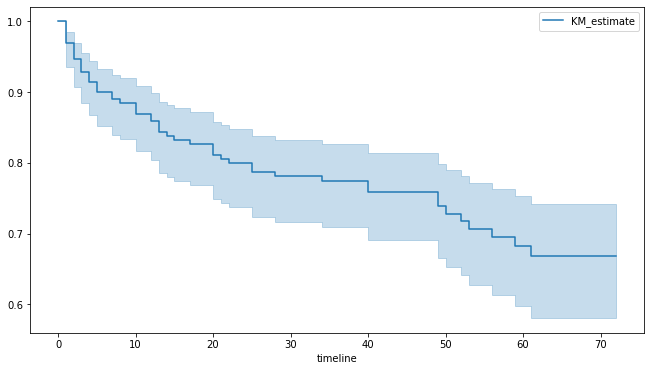

In [9]:
m = model.plot(figsize=(11,6))

## a peek at a pickeld cox hazards default model

In [10]:
from cloudpickle import load
model = load(open(os.path.join(os.getcwd(), "models/cox/model.pkl"), "rb"))
model

<lifelines.CoxPHFitter: fitted with 226 total observations, 171 right-censored observations>

In [11]:
model.print_summary()

<lifelines.CoxPHFitter: fitted with 226 total observations, 171 right-censored observations>
             duration col = 'tenure'
                event col = 'labels'
                   strata = ['InternetService', 'StreamingMovies', 'StreamingTV', 'PhoneService']
      baseline estimation = breslow
   number of observations = 226
number of events observed = 55
   partial log-likelihood = -102.57
         time fit was run = 2021-08-15 09:18:20 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
gender             0.71       2.04       0.34             0.04             1.39                 1.04                 4.00
senior            -0.33       0.72       0.44            -1.20             0.54                 0.30                 1.72
partner           -0.39       0.67       0.43            -1.24             0.45                 0.29                 1.57
deps               0.62       1.85       0.50            -0.36             1.59                 0.70                 4.93
MultipleLines     -0.79       0.45       1.09            -2.92             1.34                 0.05                 3.83
OnlineSecurity    -0.77       0.46       1.30            -3.31             1.78                 0.04                 5.93
OnlineBackup      -0.47       0.63       0.95            -2.33             1.39                 0.10                 4.03
DeviceProtection  -0.41       0.66       1.08            -2.54             1.71                 0.08                 5.54
TechSupport        0.51       1.66       1.17            -1.78             2.80                 0.17                16.43
PaperlessBilling   0.35       1.42       0.41            -0.45             1.15                 0.64                 3.16
MonthlyCharges    -0.08       0.92       0.19            -0.46             0.30                 0.63                 1.35
Contract_1        -2.19       0.11       0.71            -3.58            -0.79                 0.03                 0.45
Contract_2       -19.94       0.00    3478.68         -6838.04          6798.16                 0.00                  inf
Payment_1         -0.87       0.42       0.62            -2.07             0.34                 0.13                 1.40
Payment_2          0.46       1.58       0.45            -0.42             1.33                 0.66                 3.80
Payment_3          0.23       1.26       0.64            -1.02             1.49                 0.36                 4.43

                     z      p   -log2(p)
covariate                               
gender            2.08   0.04       4.72
senior           -0.74   0.46       1.13
partner          -0.91   0.36       1.47
deps              1.24   0.22       2.21
MultipleLines    -0.72   0.47       1.09
OnlineSecurity   -0.59   0.56       0.85
OnlineBackup     -0.49   0.62       0.68
DeviceProtection -0.38   0.70       0.51
TechSupport       0.44   0.66       0.59
PaperlessBilling  0.86   0.39       1.35
MonthlyCharges   -0.40   0.69       0.54
Contract_1       -3.07 <0.005       8.88
Contract_2       -0.01   1.00       0.01
Payment_1        -1.41   0.16       2.65
Payment_2         1.03   0.31       1.71
Payment_3         0.36   0.72       0.48
---
Concordance = 0.88
Partial AIC = 237.14
log-likelihood ratio test = 106.72 on 16 df
-log2(p) of ll-ratio test = 48.92

### some potential default analyses of coxph

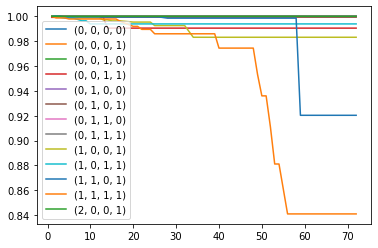

In [12]:
model.baseline_survival_.plot()

* run the following for each of the lines that passes some test (p < 0.005,for example):<br>
 `model.plot_covariate_groups('Contract_1', values=[0, 1]);`<br>
 the plot needs to have the strata decoded
 
 In the train_model above, set param `plot_cov_groups=True` and produce the following set of artifacts by selecting only those covariates whose p-values
 are below some threshold `p_value`